In [1]:
import numpy as np
import networkx as nx
from scipy.sparse import csr_array

import matplotlib.pyplot as plt
import seaborn as sns
from cci.utils import get_adata

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.5, rc=custom_params)
%config InlineBackend.figure_format="retina"

adata = get_adata("VISp")

/allen/programs/celltypes/workgroups/mousecelltypes/Donghyun/envs/miniconda3/envs/pyg/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [2]:
display(adata.obs[['brain_section_label','z_section']].sort_values('z_section').value_counts().to_frame())

,,count
brain_section_label,z_section,
C57BL6J-638850.30,5.0,9242
C57BL6J-638850.29,4.8,8713
C57BL6J-638850.28,4.6,7780
C57BL6J-638850.31,5.4,6939
C57BL6J-638850.32,5.6,6662
C57BL6J-638850.26,4.2,6379
C57BL6J-638850.25,4.0,4449
C57BL6J-638850.27,4.4,3956
C57BL6J-638850.33,5.8,2913


In [3]:
# hyperparameters
d = 40/1000 #(in mm) #<--- threshold for graph construction.#hyperparameters
L_thr = 0.0
R_thr = 0.0

In [4]:
one_sec = adata[adata.obs['z_section'] == 5.0,:]
# color palette for subclasses as a dict.
ref = one_sec.obs[['subclass_color', 'subclass']].drop_duplicates()
ref = ref.set_index('subclass').to_dict()['subclass_color']

In [5]:
lr_gene_pairs = [ ['Tac2', 'Tacr3'], ['Penk', 'Oprd1'], ['Pdyn', 'Oprd1'], ['Pdyn', 'Oprk1'], ['Grp', 'Grpr'] ] 

In [28]:
df = one_sec.obs.copy()
A_list = []
for ligand, receptor in lr_gene_pairs:
    df['L'] = one_sec[:,one_sec.var['gene_symbol']==ligand].X.toarray().ravel()
    df['R'] = one_sec[:,one_sec.var['gene_symbol']==receptor].X.toarray().ravel()

    df['L'] = (df['L'] > L_thr).astype(bool)
    df['R'] = (df['R'] > R_thr).astype(bool)

    # create a new column. if L==1, then 1, if R==1, then 2, if both 1, then 3
    df['LR'] = 0
    df.loc[(df['L']==1) & (df['R']==0), 'LR'] = 1
    df.loc[(df['L']==0) & (df['R']==1), 'LR'] = 2
    df.loc[(df['L']==1) & (df['R']==1), 'LR'] = 3

    palette = {0:'silver', 1:'dodgerblue', 2:'salmon', 3:'blueviolet'}
    palette_str =  {0:'Neither', 1:'Only ligand', 2:'Only receptor', 3:'Both'}
    # restrict df to y less than 2.75 and x between than 3.5 and 4.0
    # df_sub = df[(df['y_reconstructed'] < 2.75) & (df['x_reconstructed'] > 3.5)]
    # df_sub = df_sub[df_sub['x_reconstructed'] < 4.0]
   
    df_sub = df

    A = df_sub["L"].values.reshape(-1,1) @ df_sub["R"].values.reshape(1,-1)
    Dx = (df_sub["x_reconstructed"].values.reshape(-1,1) - df_sub["x_reconstructed"].values.reshape(1,-1))**2
    Dy = (df_sub["y_reconstructed"].values.reshape(-1,1) - df_sub["y_reconstructed"].values.reshape(1,-1))**2
    D = np.sqrt(Dx + Dy)
    del Dx, Dy

    # cells are connected only if within distance d
    A[D>d] = 0

    # remove self loops from plot
    np.fill_diagonal(A, 0)
    # construct directed graph from adjacency matrix
    A_csr = csr_array(A)
    A_list.append(A_csr)

In [29]:
from torch_geometric.utils import from_scipy_sparse_matrix
from cci.data import  get_edge_index_no_self
from torch_geometric.nn import Node2Vec
import torch
from cci.node2vec import train_node2vec, test_node2vec

from_scipy_sparse_matrix(A_list[0])

(tensor([[  20,   20,   20,  ..., 9165, 9165, 9165],
         [ 773, 4291, 4903,  ..., 2327, 2385, 9209]]),
 tensor([True, True, True,  ..., True, True, True]))

In [30]:
emb_list = []
for i in range(len(A_list)):
    edge, _ = from_scipy_sparse_matrix(A_list[i])
    edge = edge.numpy()

    edge_index_sim = get_edge_index_no_self(edge.T)

    pq = [1, 1]
    embedding_dimensions = 2
    rw_lengths = 10
    model_node2vec_list = [0 for j in range(3)] 

    model_node2vec_list[0] = Node2Vec(edge_index_sim, embedding_dim=embedding_dimensions, walk_length=rw_lengths,
            context_size=10, walks_per_node=10,
            num_negative_samples=1, p=pq[0], q=pq[1], sparse=True)
    model_node2vec_list[1] = torch.optim.SparseAdam(list(model_node2vec_list[0].parameters()), lr=0.01)
    model_node2vec_list[2] = model_node2vec_list[0].loader(batch_size=128, shuffle=True)

    epochs = 100
    loss_list = []
    for epoch in range(epochs):
        loss = train_node2vec(model_node2vec_list[0], model_node2vec_list[1], model_node2vec_list[2])
        #acc = test_node2vec()
        loss_list.append(loss)
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}', flush=True) 

    fig, ax = plt.subplots(1, 1, figsize = (5,5))
    ax.plot(loss)

    sim_emb = model_node2vec_list[0]().detach()
    max_dim = sim_emb.shape[0]
    # lin = np.round(linear_predict_sim(sim_emb, cell_type_y_list[i][:max_dim]), 2)
    # rand = np.round(rand_predict_sim(sim_emb, cell_type_y_list[i][:max_dim]), 2)
    # print("Test | Train: ", lin)
    # print("Rand: ", rand)


    embedding = model_node2vec_list[0]()
    emb_list.append(embedding)
    showplot(embedding.detach().numpy(), df['subclass_color'][:embedding.shape[0]], "PCA")

Epoch: 00, Loss: 1.8349
Epoch: 01, Loss: 1.5629
Epoch: 02, Loss: 1.3482
Epoch: 03, Loss: 1.1977
Epoch: 04, Loss: 1.0862
Epoch: 05, Loss: 1.0107
Epoch: 06, Loss: 0.9577
Epoch: 07, Loss: 0.9223
Epoch: 08, Loss: 0.8980
Epoch: 09, Loss: 0.8794
Epoch: 10, Loss: 0.8673
Epoch: 11, Loss: 0.8576
Epoch: 12, Loss: 0.8506
Epoch: 13, Loss: 0.8457
Epoch: 14, Loss: 0.8421
Epoch: 15, Loss: 0.8382
Epoch: 16, Loss: 0.8350
Epoch: 17, Loss: 0.8330
Epoch: 18, Loss: 0.8312
Epoch: 19, Loss: 0.8287
Epoch: 20, Loss: 0.8276
Epoch: 21, Loss: 0.8258
Epoch: 22, Loss: 0.8248
Epoch: 23, Loss: 0.8232
Epoch: 24, Loss: 0.8222
Epoch: 25, Loss: 0.8214
Epoch: 26, Loss: 0.8207
Epoch: 27, Loss: 0.8191
Epoch: 28, Loss: 0.8182
Epoch: 29, Loss: 0.8176
Epoch: 30, Loss: 0.8178
Epoch: 31, Loss: 0.8177
Epoch: 32, Loss: 0.8163
Epoch: 33, Loss: 0.8155
Epoch: 34, Loss: 0.8157
Epoch: 35, Loss: 0.8148
Epoch: 36, Loss: 0.8139
Epoch: 37, Loss: 0.8146
Epoch: 38, Loss: 0.8133
Epoch: 39, Loss: 0.8127
Epoch: 40, Loss: 0.8135
Epoch: 41, Loss:

[(0.0, 1.5)]

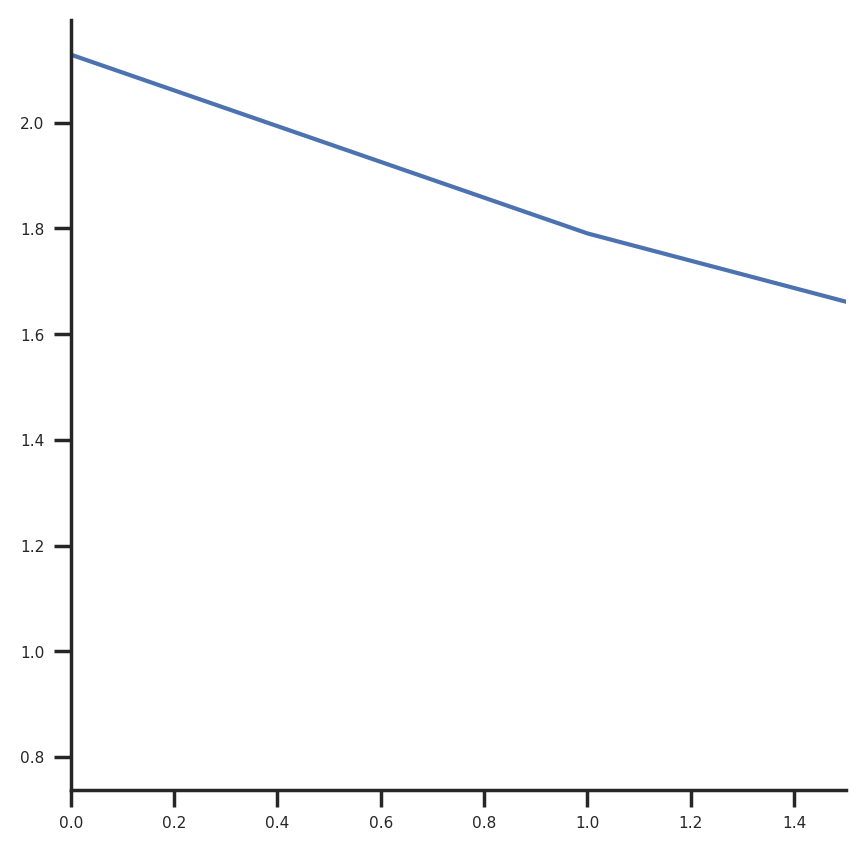

In [57]:
loss = [2.1288,1.7906,1.5324,1.3419,1.2082,1.1155,1.0452,1.0033,0.9637,0.9387,0.9194,0.9030,0.8916,0.8833,0.8738,0.8673,0.8612,0.8564,0.8531,0.8477,0.8434,0.8407,0.8377,0.8353,0.8325,0.8300,0.8283,0.8268,0.8249,0.8235,0.8216,0.8204,0.8196,0.8187,0.8170,0.8154,0.8152,0.8148,0.8146,0.8127,0.8121,0.8111,0.8115,0.8122,0.8105,0.8101,0.8097,0.8088,0.8091,0.8081,0.8094,0.8080,0.8082,0.8080,0.8092,0.8068,0.8072,0.8070,0.8077,0.8063,0.8075,0.8071,0.8070,0.8065,0.8064,0.8062,0.8058,0.8068,0.8065,0.8056,0.8061,0.8054,0.8059,0.8063,0.8053,0.8060,0.8062,0.8056,0.8066,0.8056,0.8060,0.8062,0.8055,0.8064,0.8057,0.8054,0.8065,0.8047,0.8059,0.8058,0.8060,0.8054,0.8053,0.8056,0.8054,0.8059,0.8060,0.8061,0.8067,0.8050]
fig, ax = plt.subplots(1, 1, figsize = (5,5))
ax.plot(loss)
ax.set(xlim = (0, 1.5))

In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

def linear_predict_sim(x, y):

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    print(x.shape, y.shape)
    model = LogisticRegression()
    model.fit(x_train, y_train)
    print(model)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    return [accuracy_test, accuracy_train]


def rand_predict_sim(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    strategies = ['most_frequent', 'stratified', 'uniform'] 

    test_scores = [] 
    for s in strategies: 
        dclf = DummyClassifier(strategy = s, random_state = 0) 
        dclf.fit(x_train, y_train) 
        score = dclf.score(x_test, y_test) 
        test_scores.append(score) 

    return {k:v for (k,v) in zip(strategies, test_scores)}



In [88]:
min_dim = 10000000
for i in range(len(emb_list)):
    min_dim = min(min_dim, emb_list[i].shape[0])

In [89]:
min_dim

9210

In [90]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['subclass'][:min_dim])
ordinalLabel = le.transform(df['subclass'][:min_dim])

In [92]:
for i in range(len(emb_list)):
    print(linear_predict_sim(emb_list[i].detach().numpy()[:min_dim], df['subclass'][:min_dim]))

(9210, 16) (9210,)
LogisticRegression()
[0.249185667752443, 0.24253528773072747]
(9210, 16) (9210,)
LogisticRegression()
[0.2937024972855592, 0.30320304017372424]
(9210, 16) (9210,)
LogisticRegression()
[0.2931596091205212, 0.30686753528773075]
(9210, 16) (9210,)
LogisticRegression()
[0.251357220412595, 0.24552117263843648]
(9210, 16) (9210,)
LogisticRegression()
[0.2779587404994571, 0.28691639522258416]


In [95]:
comb_emb = emb_list[0].detach().numpy()[:min_dim]
for i in range(1, len(emb_list)):
    comb_emb = np.concatenate((comb_emb,emb_list[i].detach().numpy()[:min_dim]), axis = 1)

In [97]:
print(linear_predict_sim(comb_emb[:min_dim], df['subclass'][:min_dim]))

(9210, 80) (9210,)
LogisticRegression()
[0.36210640608034744, 0.36644951140065146]


In [101]:
print(rand_predict_sim(comb_emb[:min_dim], df['subclass'][:min_dim]))

{'most_frequent': 0.251900108577633, 'stratified': 0.13680781758957655, 'uniform': 0.03474484256243214}


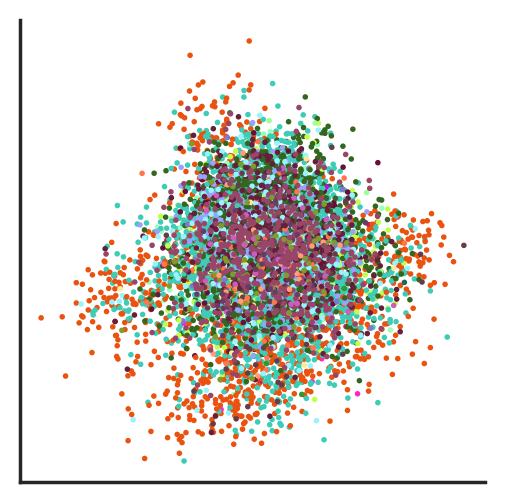

In [99]:
showplot(comb_emb[:min_dim], df['subclass_color'][:min_dim], "PCA")

In [100]:
df['subclass'][:min_dim].value_counts()

subclass
006 L4/5 IT CTX Glut         2286
007 L2/3 IT CTX Glut         1457
030 L6 CT CTX Glut           1364
319 Astro-TE NN               759
004 L6 IT CTX Glut            507
333 Endo NN                   498
022 L5 ET CTX Glut            375
052 Pvalb Gaba                333
005 L5 IT CTX Glut            329
327 Oligo NN                  285
053 Sst Gaba                  230
334 Microglia NN              114
032 L5 NP CTX Glut            111
326 OPC NN                    100
046 Vip Gaba                   95
029 L6b CTX Glut               94
049 Lamp5 Gaba                 82
331 Peri NN                    61
330 VLMC NN                    36
329 ABC NN                     28
332 SMC NN                     21
047 Sncg Gaba                  15
001 CLA-EPd-CTX Car3 Glut      13
051 Pvalb chandelier Gaba       5
002 IT EP-CLA Glut              4
056 Sst Chodl Gaba              3
003 L5/6 IT TPE-ENT Glut        1
041 OB-in Frmd7 Gaba            1
036 HPF CR Glut                 1
028 L

In [ ]:
for i in range(len(emb_list)):
    showplot(emb_list[i].detach().numpy(), df['subclass_color'][:emb_list[i].shape[0]])

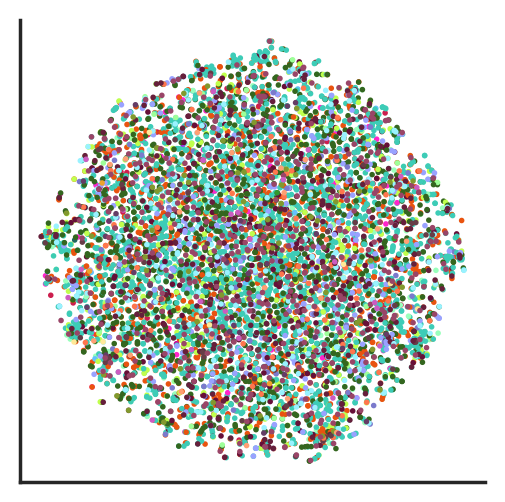

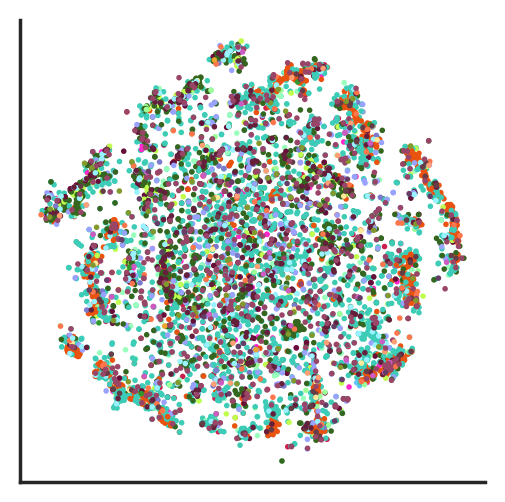

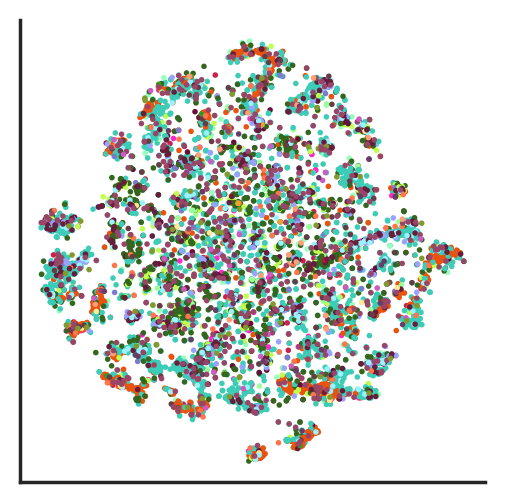

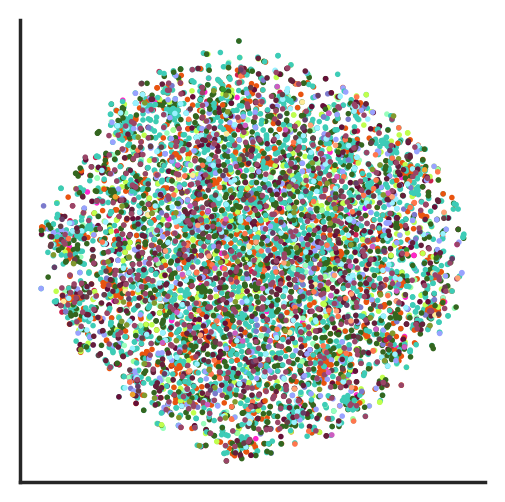

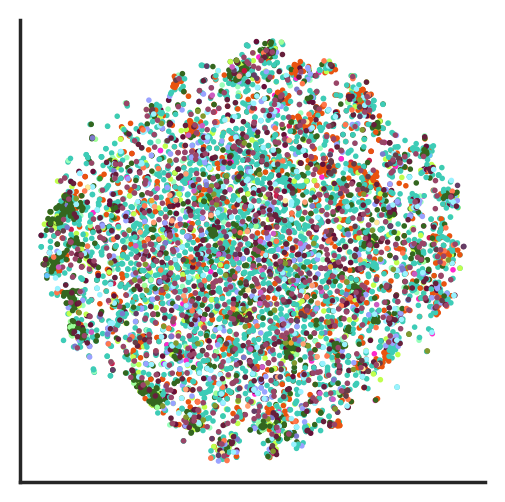

In [40]:
for i in range(len(emb_list)):
    showplot(emb_list[i].detach().numpy(), df['subclass_color'][:emb_list[i].shape[0]])

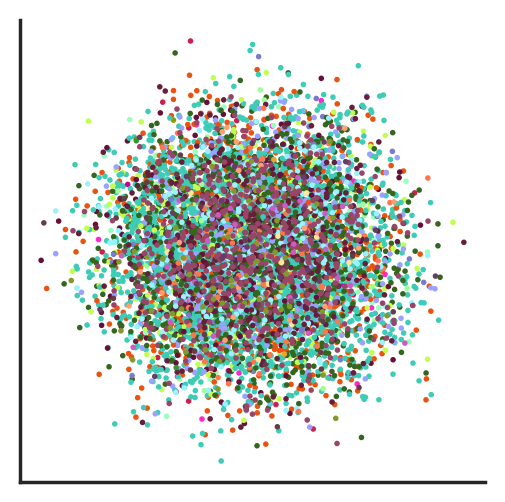

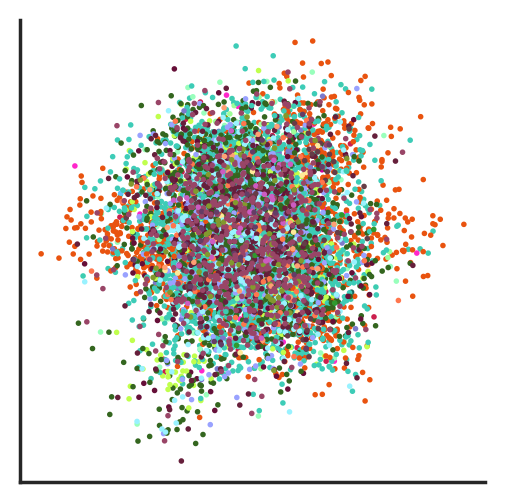

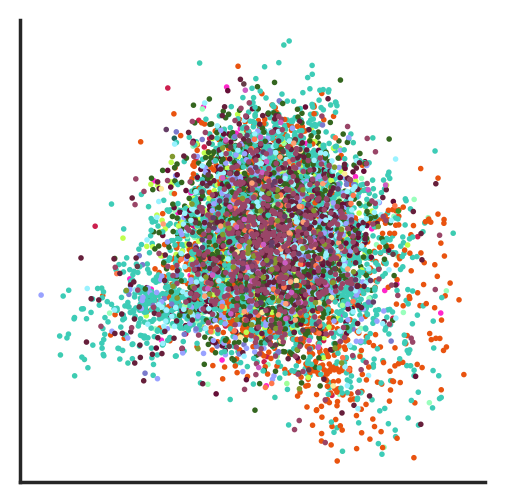

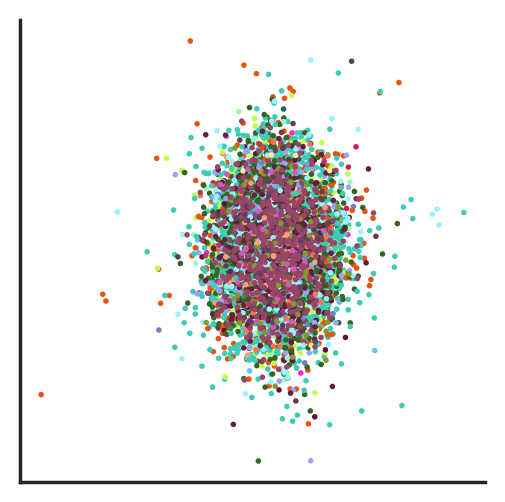

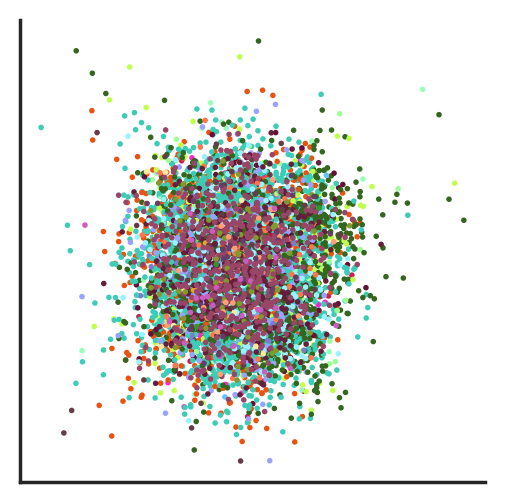

In [43]:
for i in range(len(emb_list)):
    showplot(emb_list[i].detach().numpy(), df['subclass_color'][:emb_list[i].shape[0]], "PCA")

In [42]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def showplot(embedding, color, option):
    embedding_ = embedding

    if option == "PCA":
        pca = PCA(n_components=2)
        z = pca.fit_transform(embedding_)
    else:
        z = TSNE(n_components=2).fit_transform(embedding_)

    plt.figure(figsize=(3, 3))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=1, c= color)
    # plt.savefig(fname = f'epoch_{epoch}.png', dpi = 300, format = 'png')
    plt.show()
    return
